In [ ]:
from config import SimpleConvConfig
from models.simpleconv import SimpleConv
import torch

config = SimpleConvConfig(
    # Str to list of possible conditions
    conditions={
        "studies": ["gwilliams2023", "schoffelen2022"],
    },
    # Channels
    in_channels=208,
    out_channels=128,
    hidden_dim=256,
    dropout=0.3,
    # Sensor layout settings
    layout_dim=2,
    layout_proj=False,
    layout_scaling="minmax",
    # Merger with spatial attn
    merger=True,
    merger_emb_dim=2048,
    merger_channels=256,
    merger_dropout=0.3,
    merger_conditional=None,
    # Inital
    initial_linear=256,
    initial_depth=1,
    # Conditional layers
    conditional_layers=True,
    conditional_layers_dim="hidden_dim",  # or hidden_dim
    # Conv layer overall structure
    depth=4,
    kernel_size=3,
    growth=1.0,
    dilation_growth=2,
    dilation_period=5,
    glu=1,
    conv_dropout=0.2,
    dropout_input=0.2,
    batch_norm=True,
    # Transformers Encoders
    transformer_encoder_emb="groupconv",
    transformer_encoder_layers=1,
    transformer_encoder_heads=8,
    # Transformer Decoders
    transformer_decoder_emb="groupconv",
    transformer_decoder_layers=1,
    transformer_decoder_heads=8,
    transformer_decoder_dim=256,
)

model = SimpleConv(config).to('mps')


TransEncoder 	Params: 3290112
		Spec: 256, 		Emb: groupconv, 	Bins: 16
		Layers: 1, 		D_model: 512, 		Nhead: 8

TransDecoder 	Params: 1087104
		Emb: groupconv, 	Layers: 1, 		D_model: 256
		Nhead: 8, 		Mel_bins: 128

SimpleConv: 	Params: 7725056, 	cond: ['studies']
		Merger: True, 		Merger chan: 256
		Conv blocks: 4, 	Channels: 256, 		Params: 2363904


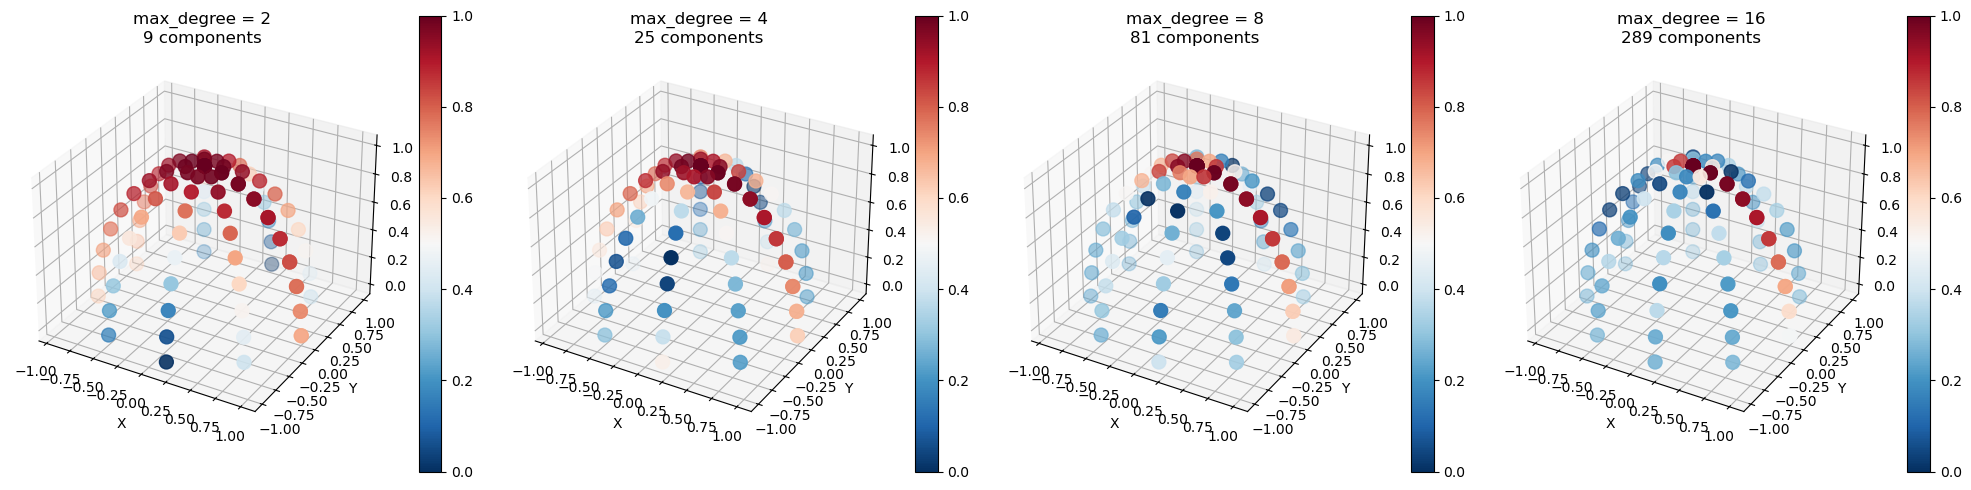

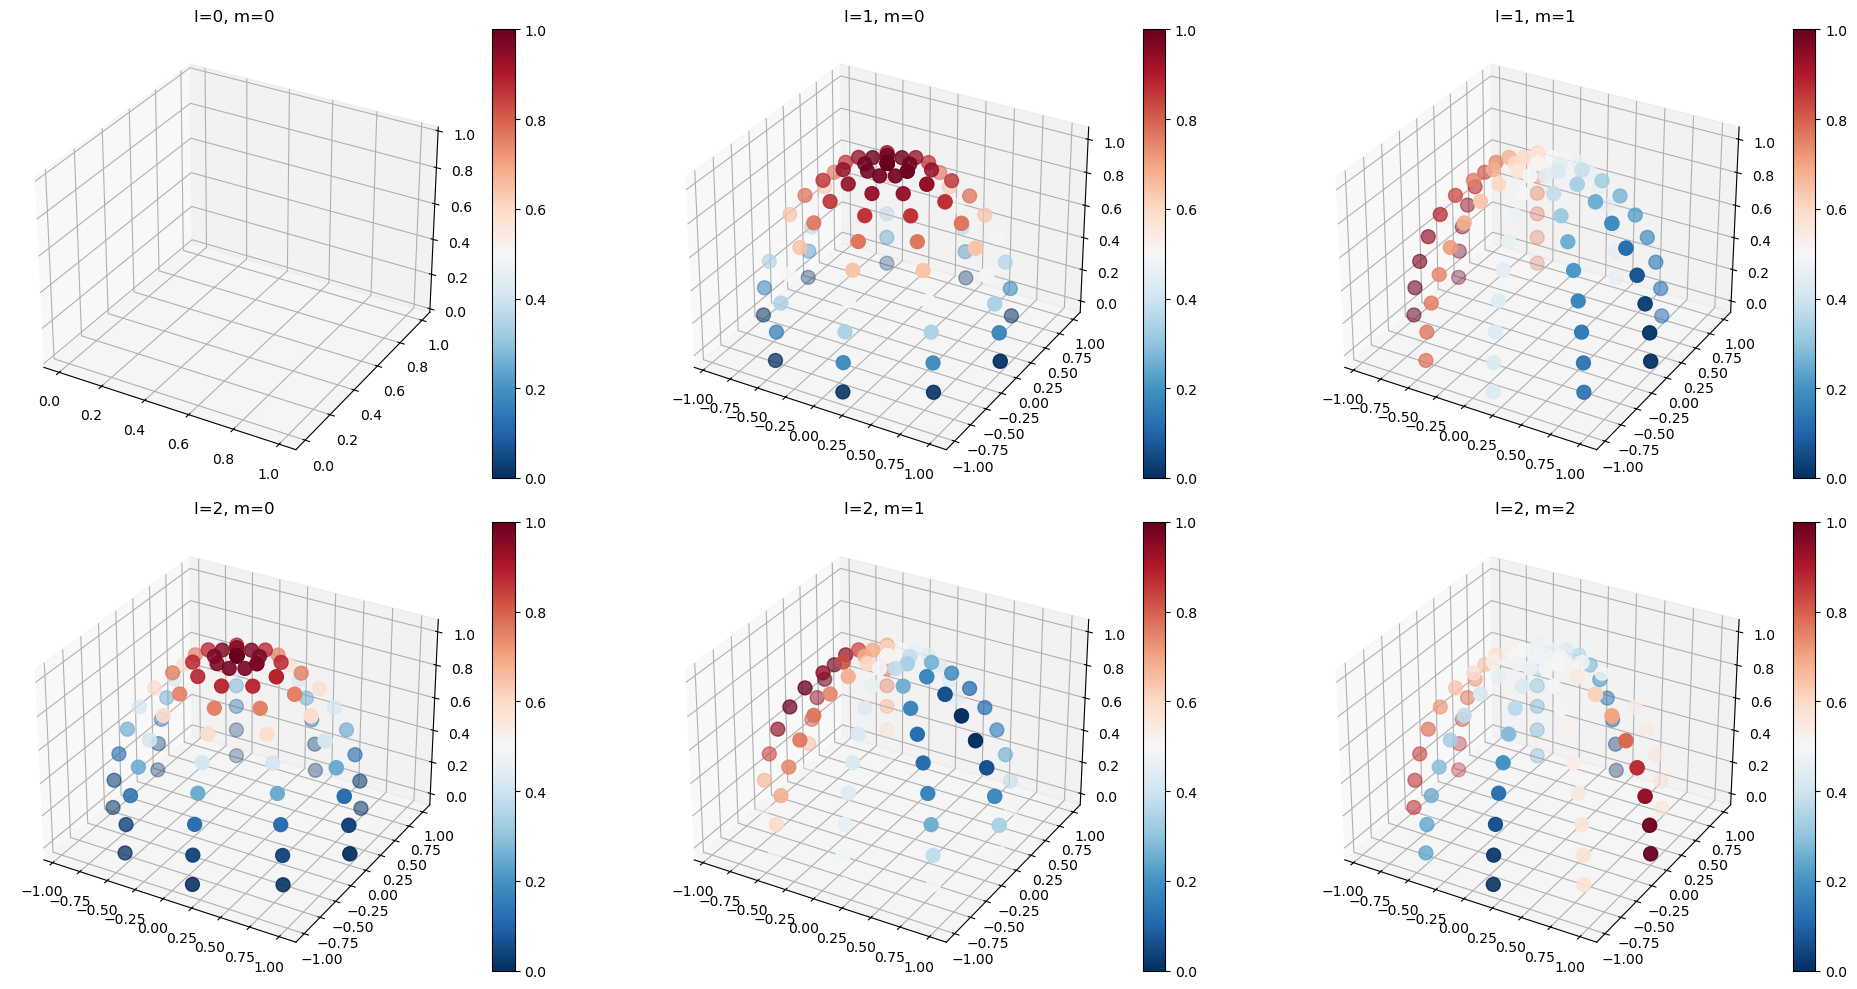

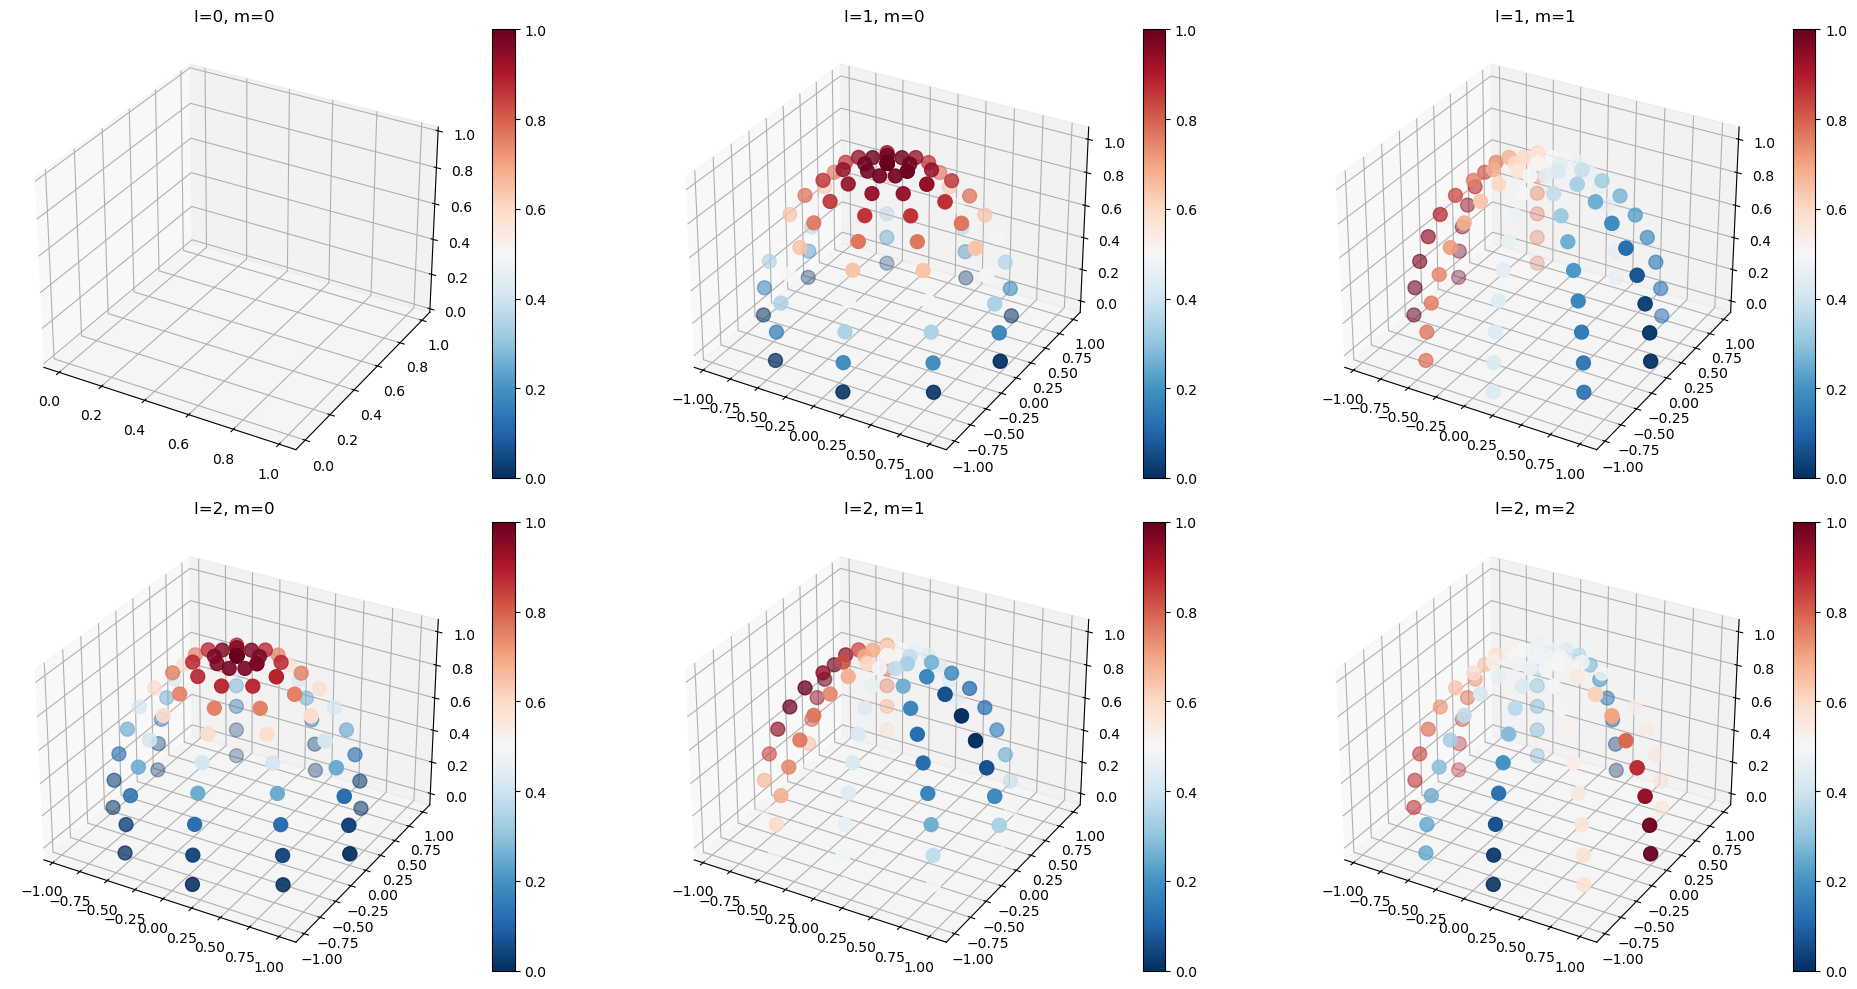

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.special import sph_harm
import torch

def create_sensor_positions(n_sensors=102):
    """Create a simplified MEG sensor layout on a hemisphere"""
    phi = np.linspace(0, 2*np.pi, int(np.sqrt(n_sensors)))
    theta = np.linspace(0, np.pi/2, int(np.sqrt(n_sensors)))
    phi, theta = np.meshgrid(phi, theta)
    
    x = np.sin(theta) * np.cos(phi)
    y = np.sin(theta) * np.sin(phi)
    z = np.cos(theta)
    
    return np.stack([x.flatten(), y.flatten(), z.flatten()], axis=1)

def visualize_harmonics(positions, max_degrees=[2, 4, 8, 16]):
    """Visualize spherical harmonics at different max_degrees"""
    fig = plt.figure(figsize=(20, 5))
    
    for idx, max_deg in enumerate(max_degrees):
        ax = fig.add_subplot(1, len(max_degrees), idx+1, projection='3d')
        
        # Convert positions to spherical coordinates
        r = np.sqrt(np.sum(positions**2, axis=1))
        theta = np.arccos(positions[:, 2] / (r + 1e-8))
        phi = np.arctan2(positions[:, 1], positions[:, 0])
        
        # Compute sample harmonic pattern
        pattern = np.zeros_like(r)
        for l in range(max_deg + 1):
            for m in range(-l, l+1):
                Y = sph_harm(m, l, phi, theta)
                pattern += Y.real
                
        # Normalize pattern
        pattern = (pattern - pattern.min()) / (pattern.max() - pattern.min())
        
        # Plot
        scatter = ax.scatter(
            positions[:, 0], positions[:, 1], positions[:, 2],
            c=pattern,
            cmap='RdBu_r',
            s=100
        )
        
        ax.set_title(f'max_degree = {max_deg}\n{(max_deg + 1)**2} components')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        plt.colorbar(scatter)
        
    plt.tight_layout()
    return fig

# Create and visualize
positions = create_sensor_positions()
fig = visualize_harmonics(positions)
plt.show()

# Now show a specific example of different l,m combinations
def plot_specific_harmonics():
    fig = plt.figure(figsize=(20, 10))
    positions = create_sensor_positions()
    r = np.sqrt(np.sum(positions**2, axis=1))
    theta = np.arccos(positions[:, 2] / (r + 1e-8))
    phi = np.arctan2(positions[:, 1], positions[:, 0])
    
    # Show some specific (l,m) combinations
    l_m_pairs = [
        (0, 0),   # Monopole
        (1, 0),   # Dipole along z
        (1, 1),   # Dipole in xy plane
        (2, 0),   # Quadrupole
        (2, 1),   # Mixed quadrupole
        (2, 2)    # Higher order
    ]
    
    for idx, (l, m) in enumerate(l_m_pairs):
        ax = fig.add_subplot(2, 3, idx+1, projection='3d')
        Y = sph_harm(m, l, phi, theta)
        pattern = Y.real
        pattern = (pattern - pattern.min()) / (pattern.max() - pattern.min())
        
        scatter = ax.scatter(
            positions[:, 0], positions[:, 1], positions[:, 2],
            c=pattern,
            cmap='RdBu_r',
            s=100
        )
        
        ax.set_title(f'l={l}, m={m}')
        plt.colorbar(scatter)
    
    plt.tight_layout()
    return fig

plot_specific_harmonics()